In [145]:
import csv
import networkx as nx
import numpy as np
from random import randint
from random import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from random import choice
from gensim.models import Word2Vec


In [170]:
# Create a graph
G = nx.read_edgelist('edgelist.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
nodes = list(G.nodes())
n = G.number_of_nodes()
m = G.number_of_edges()
edges = list(G.edges())

print('Number of nodes:', n)
print('Number of edges:', m)

Number of nodes: 138499
Number of edges: 1091955


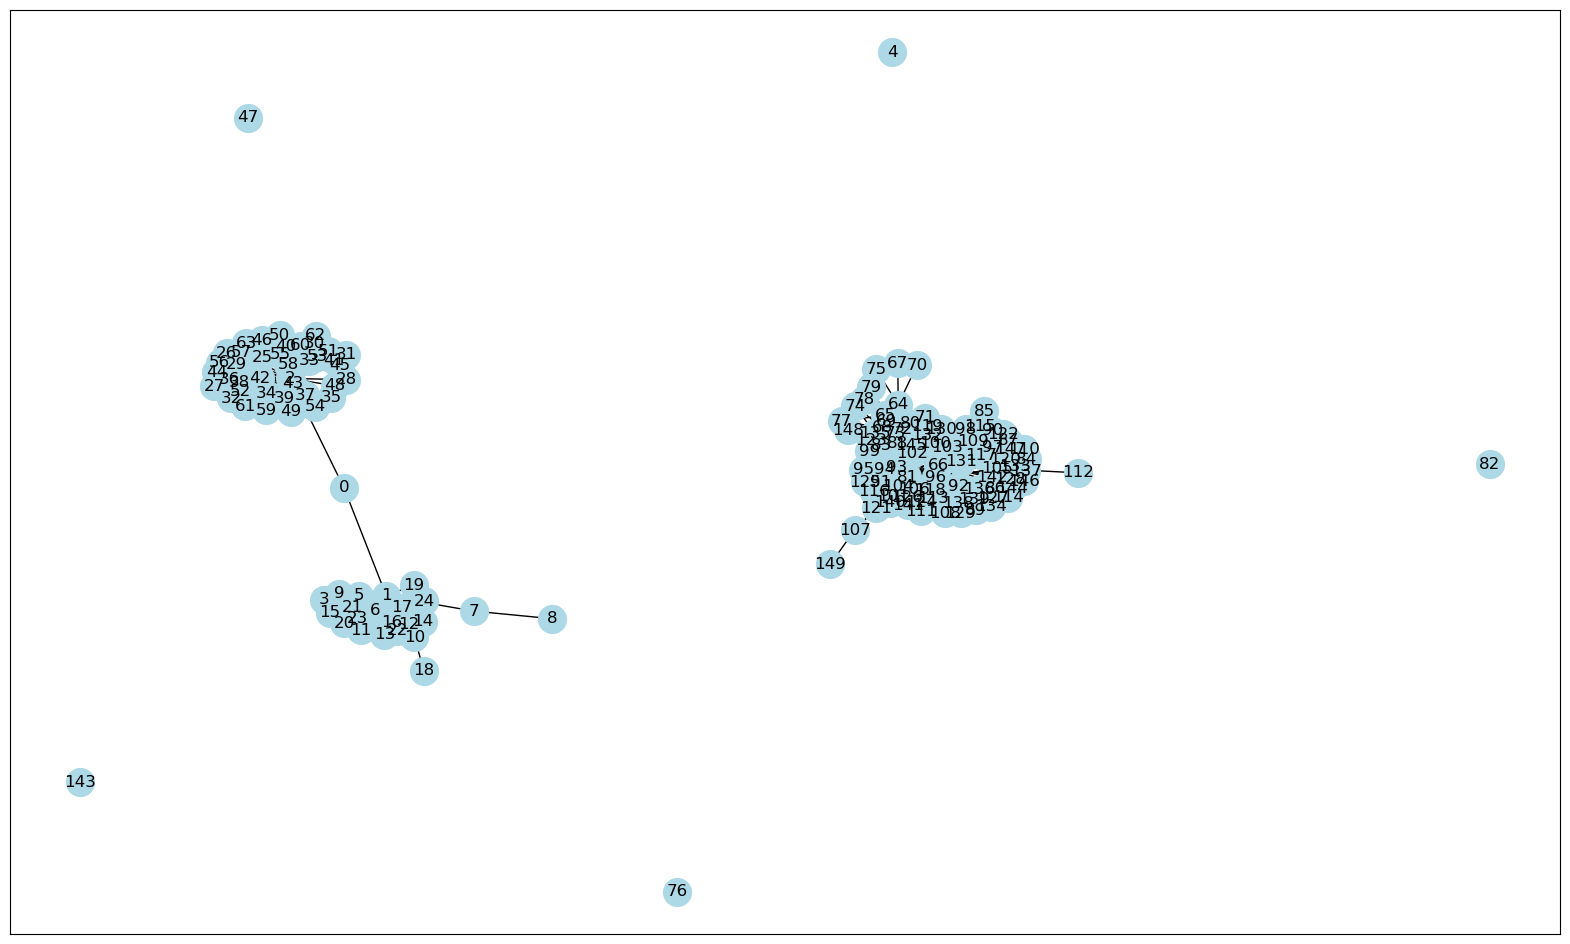

In [171]:
# display distribution of the graph (could be long to run)
plt.figure(1, figsize=(20,12))
nx.draw_networkx(G.subgraph(list(range(150))), node_color='lightblue', node_size=400)

In [172]:
# We need to create a seperate validation subset 
# with 0.1 edges from the graph

val_edges = list()
G_train = G

for edge in edges:
    if random() < 0.1:
        val_edges.append(edge)

# We remove the val edges from the graph G
for edge in val_edges:
    G_train.remove_edge(edge[0], edge[1])

n = G_train.number_of_nodes()
m = G_train.number_of_edges()
train_edges = list(G_train.edges())
    
print('Number of nodes of training set:', n)
print('Number of edges of training set:', m)


Number of nodes of training set: 138499
Number of edges of training set: 982392


In [173]:
y_val = [1]*len(val_edges)

n_val_edges = len(val_edges)

# Create random pairs of nodes
for i in range(n_val_edges):
    n1 = nodes[randint(0, n-1)]
    n2 = nodes[randint(0, n-1)]
    (n1, n2) = (min(n1, n2), max(n1, n2))
    val_edges.append((n1, n2))
    
# Remove edges that exist in both train and val

print('intersection: ', list(set(val_edges) & set(train_edges)))
for edge in list(set(val_edges) & set(train_edges)):
    val_edges.remove(edge)
    
print('cleaned:', list(set(val_edges) & set(train_edges)))


intersection:  [(5134, 5973), (21822, 41294), (27142, 79452), (41688, 48521), (36116, 85926), (9282, 53490), (102935, 103000), (50945, 66779)]
cleaned: []


In [174]:
n_val_edges = len(val_edges) - len(y_val)
y_val.extend([0]*n_val_edges)

In [186]:
print(len(val_edges))
print(len(y_val))
print(len(val_edges) - len(y_val))

219118
219118
0


In [123]:
# Define a function that generates a random walk for a given graph node and walk length

def random_walk(G, node, walk_length):
    # Starts from vertex "node" and performs a random walk of length "walk length". Returns a list of the visited vertices
    walk = [node]
  
    # your code here
    for i in range(walk_length-1) :
        neibor_nodes = list(G.neighbors(walk[-1]))
        if len(neibor_nodes) > 0 :
            #print('neibor_nodes : ', neibor_nodes)
            next_node = choice(neibor_nodes)
            walk.append(next_node)
    
    walk = [str(node) for node in walk] # in case the nodes are in string format, we don't need to cast into string, but if the nodes are in numeric or integer, we need this line to cast into string
    return walk


# Define a second function that generates num_walks random walks with a given length for all the nodes of a graph

def generate_walks(G, num_walks, walk_length):
    # Runs "num_walks" random walks from each node, and returns a list of all random walk
    walks = list()
  
    # your code here
    for i in range(num_walks) :
        for node in G.nodes() :
            #print(node)
            walk = random_walk(G, node, walk_length)
            walks.append(walk)
        #print('walks : ', walks)
    return walks

In [143]:
# Generate walks in a variable called walks which is a list of walk(s) which is a sequence of nodes
walks = generate_walks(G,30,20)

In [164]:
vector_size = 64
model = Word2Vec(vector_size=vector_size, window=5, min_count=0, sg=1, workers=8)
model.build_vocab(walks)
model.train(walks, total_examples=model.corpus_count, epochs=5) 


In [163]:
len(model.wv['138498'])

64

In [180]:
# Create the train matrix
# Now we start with only 2 features for each edge
# which are the sum of degrees of the two nodes and absolute difference of 

X_train = np.zeros((2*m, 2 + 2*vector_size))
y_train = np.zeros(2*m)

for i, edge in enumerate(train_edges):
    X_train[2*i, 0] = G.degree(edge[0]) + G.degree(edge[1])
    X_train[2*i, 1] = abs(G.degree(edge[0]) - G.degree(edge[1]))
    X_train[2*i, 2:2+vector_size] = model.wv[str(edge[0])]
    X_train[2*i, 2+vector_size:2+2*vector_size] = model.wv[str(edge[1])]    
    y_train[2*i] = 1
    
    # a randomly generated pair of nodes
    n1 = nodes[randint(0, n-1)]
    n2 = nodes[randint(0, n-1)]
    X_train[2*i+1,0] = G.degree(n1) + G.degree(n2)
    X_train[2*i+1,1] = abs(G.degree(n1) - G.degree(n2))
    X_train[2*i+1, 2:2+vector_size] = model.wv[str(G.degree(min(n1, n2)))]
    X_train[2*i+1, 2+vector_size:2+2*vector_size] = model.wv[str(G.degree(max(n1, n2)))]  
    y_train[2*i+1] = 0


In [176]:
#Create the validation (test) matrix. Use the same 2 (or more) features as above (for train matrix) 
#for all edges in new complete val set

X_val = np.zeros((len(val_edges), 2 + 2*vector_size))

for i,edge in enumerate(val_edges):
    X_val[i,0] = G.degree(edge[0]) + G.degree(edge[1])
    X_val[i,1] = abs(G.degree(edge[0]) - G.degree(edge[1]))
    X_val[i, 2:2+vector_size] = model.wv[str(edge[0])]
    X_val[i, 2+vector_size:2+2*vector_size] = model.wv[str(edge[1])]  

print(X_val.shape)
print(len(y_val))

(219118, 130)
219118


In [270]:
# Use logistic regression to predict if two nodes are linked by an edge
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_clf = clf.predict_proba(X_val)
y_pred_clf = y_pred_clf[:,1]

loss = log_loss(y_val, y_pred_clf)
print(loss)

#with only two features = 0.48721999679009104

/Users/ghassenabdedayem/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5.048268792799987


In [276]:
list(y_pred_clf)


[2.9308633596125526e-06,
 1.8285825798051342e-06,
 0.00018010361921157043,
 0.009074969465009906,
 0.0008403925544268316,
 0.0006560786348754336,
 0.0001513663998105928,
 0.0004102470427379651,
 0.05336999206501519,
 0.0003441838481176829,
 0.00017331104978383195,
 0.09579745455041092,
 0.0001105144252278298,
 0.003299880359185067,
 0.009804538023290146,
 0.030642080758726164,
 0.002056275373601293,
 0.006318539794622676,
 0.0032727708441657325,
 0.07280062286685386,
 0.020066915415313722,
 0.057509225842244195,
 0.0037814273114626083,
 0.00015192473232964062,
 0.028040119645645536,
 0.03061063713476646,
 0.9981763022285606,
 0.24760409634813707,
 0.16219425639521348,
 0.00396486979230321,
 0.1661086844533481,
 0.9104275662292239,
 0.11896665996330712,
 0.02713643454588916,
 0.0826618072635829,
 0.26586012451987595,
 0.03445319744573133,
 0.03240636719125421,
 0.033134899875491904,
 0.039691231211946315,
 0.0017165391571514243,
 0.0023375149133672475,
 0.14570100808638164,
 0.001049558

In [127]:
y_pred_clf.shape

(217372, 2)

In [ ]:
# Random forest classifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict_proba(X_val)

rf_y_pred = rf_y_pred[:,1]

loss = log_loss(y_val, rf_y_pred)
print(loss)

#with only two features = 0.7249382635266391

In [232]:
def multi_layers (input_dim, output_dim=3):
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_dim,)))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(Dense(units = output_dim, activation = "softmax"))
    return model 

multi_layers_model = multi_layers(130, 1) 
# multi_layers_model.summary()

multi_layers_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model_checkpoint = ModelCheckpoint("multi_layers_model.h5", monitor='val_accuracy', save_best_only=True)
adam = keras.optimizers.Adam(learning_rate=0.1)

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)


multi_layers_model.fit(
    x = X_train, 
    y = y_train, 
    epochs = 50,
    batch_size = 200,
    validation_data = (X_val, y_val_array),
    callbacks = [model_checkpoint, early_stop], 
)

Epoch 1/50


/Users/ghassenabdedayem/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9824/9824 [==============================] - 116s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/50
9824/9824 [==============================] - 125s 13ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/50
9824/9824 [==============================] - 111s 11ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/50
9824/9824 [==============================] - 114s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/50
9824/9824 [==============================] - 107s 11ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/50
9824/9824 [==============================] - 97s 10ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 7/50
9824/9824 [==============================] - 97s 10ms/step - loss: 0.00

In [236]:
del(y_pred)
y_pred = multi_layers_model.predict(X_val)

6848/6848 [==============================] - 8s 1ms/step


In [262]:
list_y_pred = list()
for element in y_pred:
    list_y_pred.append(element[0])

    
print(len(list_y_pred), len(y_val))

219118 219118


In [281]:
list_y_pred[len(y_val)-1]

# loss = log_loss(y_val, list_y_pred)
# print(loss)

1.0

In [231]:
# y_val_ndarray = np.ndarray(shape=(len(y_val),), buffer=y_val)
y_val_array = np.array(y_val)
print(y_val_array.shape, y_train.shape)

(219118,) (1964784,)


In [199]:
# Deep leaning with multi layers perceptron

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf
tf.config.run_functions_eagerly(True)

def multi_layers (input_dim=130, output_dim=3):
    model = keras.Sequential()
    model.add(Dense(45, input_shape=(,input_dim)))
    model.add(Dense(units = 40, activation = "relu"))
    model.add(Dense(units = 40, activation = "relu"))
    model.add(Dense(units = 40, activation = "relu"))
    model.add(BatchNormalization())
    
    model.add(Dense(units = 30, activation = "relu"))
    model.add(Dense(units = 30, activation = "relu"))
    model.add(Dense(units = 30, activation = "relu"))
    model.add(BatchNormalization())
    
    model.add(Dense(units = 20, activation = "relu"))
    model.add(Dense(units = 20, activation = "relu"))
    model.add(Dense(units = 20, activation = "relu"))
    model.add(BatchNormalization())    
    
    model.add(Dense(units = 10, activation = "relu"))
    model.add(Dense(units = 10, activation = "relu"))
    model.add(Dense(units = 10, activation = "relu"))
    model.add(BatchNormalization()) 
    
    model.add(Dense(units = 5, activation = "relu"))
    model.add(Dense(units = 5, activation = "relu"))
    model.add(Dense(units = 5, activation = "relu"))
    model.add(BatchNormalization())   
    
    model.add(Dense(units = output_dim, activation = "softmax")) 

    return model 

multi_layers_model = multi_layers(45, 3) 
multi_layers_model.summary()

SyntaxError: invalid syntax (1688544465.py, line 12)

In [203]:
multi_layers_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint("multi_layers_model.h5", monitor='val_accuracy', save_best_only=True)
adam = keras.optimizers.Adam(learning_rate=0.1)

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

multi_layers_model.fit(
    x = X_train, 
    y = y_train, 
    epochs = 50,
    batch_size = 45,
    validation_data = (X_val, y_val),
    callbacks = [model_checkpoint, early_stop], 
)

Epoch 1/50


ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 45), found shape=(45, 130)

In [201]:
multi_layers_model.fit(
    x = X_train, 
    y = y_train, 
    epochs = 50,
    batch_size = 45,
    validation_data = (X_val, y_val),
    callbacks = [model_checkpoint, early_stop], 
)

Epoch 1/50


/Users/ghassenabdedayem/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 45), found shape=(45, 130)

In [191]:
X_train.shape

(1964784, 130)

### Draft from camp or baseline

In [20]:

# y_val = [1]*len(val_edges)
# len(y_val)
# false_edges = list()
# n_val_edges = len(val_edges)

# #create random pairs of nodes
# for i in range(n_val_edges):
#     n1 = nodes[randint(0, n-1)]
#     n2 = nodes[randint(0, n-1)]
#     if (n1, n2) in edges or (n2, n1) in edges:
#         false_edges.append((n1, n2))





#Create the test matrix. Use the same 4 features as above for all edges in new complete val set
X_val = np.zeros((len(val_edges), 132))

for i,node_pair in enumerate(val_edges):
    X_val[i,0] = G.in_degree(node_pair[0])
    X_val[i,1] = G.out_degree(node_pair[0])
    X_val[i,2] = G.in_degree(node_pair[1])
    X_val[i,3] = G.out_degree(node_pair[1])
    X_val[i,4:68] = model.wv[str(node_pair[0])]
    X_val[i,68:132] = model.wv[str(node_pair[0])]



109376

In [3]:




# Create the training matrix. Each row corresponds to a pair of nodes and
# its class label is 1 if it corresponds to an edge and 0, otherwise.
# Use the following 2 features for each pair of nodes:
# (1) sum of degrees of two nodes
# (2) absolute value of difference of degrees of two nodes
X_train = np.zeros((2*m, 2))
y_train = np.zeros(2*m)
for i,edge in enumerate(G.edges()):
    # an edge
    X_train[2*i,0] = G.degree(edge[0]) + G.degree(edge[1])
    X_train[2*i,1] = abs(G.degree(edge[0]) - G.degree(edge[1]))
    y_train[2*i] = 1

    # a randomly generated pair of nodes
    n1 = nodes[randint(0, n-1)]
    n2 = nodes[randint(0, n-1)]
    X_train[2*i+1,0] = G.degree(n1) + G.degree(n2)
    X_train[2*i+1,1] = abs(G.degree(n1) - G.degree(n2))
    y_train[2*i+1] = 0

print('Size of training matrix:', X_train.shape)

# Read test data. Each sample is a pair of nodes
node_pairs = list()
with open('test.txt', 'r') as f:
    for line in f:
        t = line.split(',')
        node_pairs.append((int(t[0]), int(t[1])))

# Create the test matrix. Use the same 2 features as above
X_test = np.zeros((len(node_pairs), 2))
for i,node_pair in enumerate(node_pairs):
    X_test[i,0] = G.degree(node_pair[0]) + G.degree(node_pair[1])
    X_test[i,1] = abs(G.degree(node_pair[0]) - G.degree(node_pair[1]))

print('Size of test matrix:', X_test.shape)

# Use logistic regression to predict if two nodes are linked by an edge
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
y_pred = y_pred[:,1]

# Write predictions to a file
predictions = zip(range(len(y_pred)), y_pred)
with open("submission.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row) 

Size of training matrix: (2183910, 2)
Size of test matrix: (106692, 2)


In [4]:
import pandas as pd
submissions = pd.read_csv("submission.csv")

submissions.shape

(106692, 2)

In [12]:
from sklearn.metrics import log_loss
from random import choice


def random_walk(G, node, walk_length):
    # Starts from vertex "node" and performs a random walk of length "walk length". Returns a list of the visited vertices
    walk = [node]
  
    # your code here
    for i in range(walk_length-1) :
        neibor_nodes = list(G.neighbors(walk[-1]))
        if len(neibor_nodes) > 0 :
            #print('neibor_nodes : ', neibor_nodes)
            next_node = choice(neibor_nodes)
            walk.append(next_node)
    
    walk = [str(node) for node in walk] # in case the nodes are in string format, we don't need to cast into string, but if the nodes are in numeric or integer, we need this line to cast into string
    return walk

In [13]:
import numpy as np

def generate_walks(G, num_walks, walk_length):
    # Runs "num_walks" random walks from each node, and returns a list of all random walk
    walks = list()
  
    # your code here
    for i in range(num_walks) :
        for node in G.nodes() :
            #print(node)
            walk = random_walk(G, node, walk_length)
            walks.append(walk)
        #print('walks : ', walks)
    return walks

In [14]:
walks = generate_walks(G,30,20)

In [19]:
print(walks[0])
print(walks[1])

['0', '2', '28', '43549', '27150', '48903', '63122', '18584', '6964', '17895', '17891', '17895', '18406', '7070', '77758', '7070', '18468', '34133', '65767', '84461']
['1', '0', '1', '15', '113938', '107391', '58360', '78372', '74531', '38703', '74545', '36559', '48238', '92761', '92768', '80129', '6399', '131405', '6399', '80129']


In [22]:
from gensim.models import Word2Vec

# your code here
model = Word2Vec(vector_size=64, window=5, min_count=0, sg=1, workers=8)
model.build_vocab(walks)

In [23]:
model.train(walks, total_examples=model.corpus_count, epochs=5) 

(415497000, 415497000)

In [24]:
model.wv['32098']

array([ 0.22521242, -0.42673787,  0.12007466,  0.7780592 , -0.51929784,
        0.07683643, -0.5981351 ,  0.39624748, -0.37837535, -1.826906  ,
        1.0220132 , -0.25870925, -0.04830848, -0.2518258 ,  0.69947624,
       -0.18464538,  0.6723689 , -0.12936735, -0.05660066,  0.38391775,
        0.75740236, -0.6409525 , -0.30568057, -0.6648211 ,  0.55814856,
        0.59046626, -0.10460854,  0.36981013, -0.3843997 , -0.0207953 ,
       -0.03860374, -0.2059817 ,  1.4586298 , -0.5290313 , -0.03813402,
       -0.01081022,  0.7109848 , -0.04752702, -0.100824  , -0.38457453,
       -0.5199413 ,  0.05879361,  0.6316851 , -0.7834767 ,  0.14467937,
       -0.43016955, -0.2009833 , -0.7065504 , -0.12999064,  1.4122663 ,
       -0.28577116,  0.3747891 ,  0.14176191,  0.5266504 , -0.25955018,
       -0.43231076,  0.1977542 , -0.9803466 , -0.9263578 , -0.06170238,
       -0.14124955,  0.19904314, -0.8429384 , -0.13034417], dtype=float32)

In [35]:
randint(3,10)

5